# Ground-State: Ising model

Author: Filippo Vicentini (EPFL-CQSL)

17 November, 2021

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/NetKet-lectures/blob/master/01_intro.ipynb)

In this Tutorial we will introduce the open-source package [NetKet](https://www.netket.org/), and show some of its functionalities. We will guide you through a relatively simple quantum problem, that however will be a good guide also to address more complex situations.

Specifically, we will study the transverse-field Ising model in one dimension:

$$
\mathcal{H}=\Gamma\sum_{i}\sigma_{i}^{(x)}+V\sum_{i}\sigma_{i}^{(z)}\sigma_{i+1}^{(z)}.
$$

In the following we assume periodic boundary conditions and we will count lattice sites starting from $ 0 $, such that $ i=0,1\dots L-1 $ and $i=L=0$.

## 0. Installing Netket

If you are executing this notebook on Colab, you will need to install netket. You can do so by running the following cell:

In [1]:
%pip install --quiet netket

Note: you may need to restart the kernel to use updated packages.


We also want make to sure that this notebook is running on the cpu.
You can edit the field by changing "cpu" to "gpu" to make it run on the GPU if you want.
But you'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [1]:
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

You can check that the installation was successful doing

## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in.
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc).
This is done specifying the Hilbert space of the problem. For example, let us concentrate on a problem with 20 spins-1/2.

When building hilbert spaces, in general, the first argument determines the size of the local basis and the latter defines how many modes you have.

In [14]:
import netket as nk

N = 5
hi = nk.hilbert.Spin(s=1 / 2, N=N)

NetKet's Hilbert spaces define the computational basis of the calculation, and are used to label and generate elements from it.
The standard Spin-basis implicitly selects the `z` basis and elements of that basis will be elements $ v\in\{\pm 1\}^N $.

It is possible to generate random basis elements through the function `random_state(rng, shape, dtype)`, where the first argument must be a jax RNG state (usually built with `jax.random.key(seed)`, second is an integer or a tuple giving the shape of the samples and the last is the dtype of the generated states.

In [15]:
import jax

hi.random_state(jax.random.key(0), 3)

Array([[-1, -1, -1, -1, -1],
       [-1,  1,  1,  1,  1],
       [ 1, -1,  1,  1, -1]], dtype=int8)

We now need to specify the Hamiltonian. For this purpose, we will use NetKet's ```LocalOperator``` (see details [here](https://www.netket.org/docs/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator)) which is the sum of arbitrary k-local operators.

In this specific case, we have a 1-local operator, $ \sigma^{(x)}_i $ and a 2-local operator, $ \sigma^{(z)}_i \sigma^{(z)}_j $. We then start importing the pauli operators.



In [16]:
from netket.operator.spin import sigmax, sigmaz

We now take $ \Gamma=-1 $ and start defining the 1-local parts of the Hamiltonian

In [17]:
Gamma = -1
H = sum([Gamma * sigmax(hi, i) for i in range(N)])

Here we have used a list comprehension to (mildly) show off our ability to write one-liners, however you could have just added the terms one by one in an explicit loop instead (though you'd end up with a whopping 3 lines of code).

We now also add the interaction terms, using the fact that NetKet automatically recognizes products of local operators as tensor products.

In [18]:
V = -1
H += sum([V * sigmaz(hi, i) * sigmaz(hi, (i + 1) % N) for i in range(N)])

In general, when manipulating NetKet objects, you should always assume that you can safely operate on them like
you would in mathematical equations, therefore you can sum and multiply them with ease.

## 2. Exact Diagonalization

Now that we have defined the Hamiltonian, we can already start playing with it. For example, since the number of spins is large but still manageable for exact diagonalization, we can give it a try.

In NetKet this is easily done converting our Hamiltonian operator into a sparse matrix of size $ 2^N \times 2^ N $.

In [24]:
sp_h = H.to_sparse()
sp_h.shape

(32, 32)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates

In [ ]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)
print("ground state ", eig_vecs)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-6.47213595]
ground state  [[0.54406272]
 [0.16018686]
 [0.16018686]
 [0.10881254]
 [0.16018686]
 [0.05743823]
 [0.10881254]
 [0.10881254]
 [0.16018686]
 [0.05743823]
 [0.05743823]
 [0.05743823]
 [0.10881254]
 [0.05743823]
 [0.10881254]
 [0.16018686]
 [0.16018686]
 [0.10881254]
 [0.05743823]
 [0.10881254]
 [0.05743823]
 [0.05743823]
 [0.05743823]
 [0.16018686]
 [0.10881254]
 [0.10881254]
 [0.05743823]
 [0.16018686]
 [0.10881254]
 [0.16018686]
 [0.16018686]
 [0.54406272]]


## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz:

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized:

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive.

For the normalized single-spin probability we will take a sigmoid form:

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)), $$

thus depending on the real-valued variational parameter $\lambda$.
In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_ (yes, caps on the M).

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$

where $\theta$ is a set of parameters.
In this case, the parameter of the model will be just one: $\gamma$.

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku.
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), so we will be using it for the rest of the notebook.

In [ ]:
# numerical operations in the model should always use jax.numpy
# instead of numpy because jax supports computing derivatives.
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax

# Flax has two 'neural network' libraries. THe  first one is `flax.linen`
# which has been in use since 2020, and most examples use it. The new one,
# nnx, is somewhat simpler to use, and it's the one we will use here.
from flax import nnx


# An NNX model must be a class subclassing `nnx.Module`
class MF(nnx.Module):
    """
    A class implementing a uniform mean-field model.
    """

    # The __init__ function is used to define the parameters of the model
    # The RNG argument is used to initialize the parameters of the model.
    def __init__(self, *, rngs: nnx.Rngs):
        # To generate random numbers we need to extract the key from the
        # `rngs` object.
        key = rngs.params()
        # We store the log-wavefunction on a single site, and we call it
        # `log_phi_local`. This is a variational parameter, and it will be
        # optimized during training.
        #
        # We store a single real parameter, as we assume the wavefunction
        # is normalised, and initialise it according to a normal distibution.
        self.log_phi_local = nnx.Param(jax.random.normal(key, (1,)))

    # The __call__(self, x) function should take as
    # input a batch of states x.shape = (n_samples, N) (these are states for example "n_samples" tuples of "N" spins)
    # and should return a vector of n_samples log-amplitudes (these are the Amplitudes of each tuple of spins given in input )
    # The model has a rapresentation of the state embedded in its parameters, to extract it do a Markov chain Monte Carlo sampling
    def __call__(self, x: jax.Array):

        # compute the probabilities
        p = nnx.log_sigmoid(self.log_phi_local * x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

Here we use ``flax.nnx`` to construct the model, which is a more modern and simpler neural-network library when compared to ``flax.linen``, which is what was used in NetKet for many years. In fact, you can use both those libraries with NetKet! Just be careful that the two are quite different.

To actually create a variational state the easiest way is to construct a Monte-Carlo-sampled Variational State.
To do this, we first need to define a sampler.

In `netket.sampler` several samplers are defined, each with its own peculiarities.
In the following example, we will be using a simple sampler that flips the spins in the configurations one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [35]:
# Create an instance of the model, using the seed 0
mf_model = MF(rngs=nnx.Rngs(0))
# If you want to learn more about how to use this model, check the nnx tutorial
# https://flax.readthedocs.io/en/latest/nnx_basics.html

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=128)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters.
The parameters are stored as a set of nested dictionaries. In this case, the single parameter $\lambda$ is stored inside a (frozen) dictionary.
(The reason why the dictionary is frozen is a detail of Flax).

In [36]:
print(vstate.parameters)

{'log_phi_local': Array([1.88002989], dtype=float64)}


With a variational state, you can compute expectation values of operators.
Notice that it also provides an error estimate and the variance of this estimator.
If you are close to an eigenstate of the operators, the variance should be 0 or close to 0.

The $\hat{R}$ value is a Monte-Carlo convergence estimator. It will be $\hat{R}\approx 1$ if the Markov Chain is converged, while it will be far from $1$ if your sampling has not converged.
As a rule of thumb, look out for $|\hat{R}| > 1.1$, and check if your sampling scheme or sampler is consistent with your system specification.

You can also investigate the correlation time of your estimator, $\tau$. If $\tau\gg1$ then your samples are very correlated and you most likely have some issues with your sampling scheme.

In [ ]:
E = vstate.expect(H) #you can evaluate the expectation value of the energy of vstate with MC sampling
print(E)

-6.09 ± 0.10 [σ²=1.3e+00, R̂=1.109]


You can also access the fields individually:
Note that if you run your calculation using MPI on different processes/machines, those estimators will return the mean, error and estimators of all the samples across all the processes.

In [38]:
print("Mean                  :", E.mean)
print("Error                 :", E.error_of_mean)
print("Variance              :", E.variance)
print("Convergence indicator :", E.R_hat)
print("Correlation time      :", E.tau_corr)

Mean                  : -6.092880376048572
Error                 : 0.10164798290116794
Variance              : 1.3225359907681447
Convergence indicator : 1.1094782081024042
Correlation time      : 0.0


In [39]:
vstate.expect_and_grad(H)

(-6.09 ± 0.10 [σ²=1.3e+00, R̂=1.109],
 {'log_phi_local': Array([-0.47495824], dtype=float64)})

## 4. Variational Monte Carlo

We will now try to optimise $ \lambda $ in order to best approximate the ground state of the hamiltonian.

At first, we'll try to do this by ourselves by writing the training loop, but then we'll switch to using a pre-made
solution provided by netket for simplicity.

### 4a. DIY Optimisation loop

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it's gradient, then multiply the gradient by a certain learning rate $\lambda = 0.05$ and lastly it must update the parameters with this rescaled gradient.
You can do so as follows:

In [ ]:
from tqdm import tqdm

energy_history = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    # compute energy and gradient of the energy with MC sampling with Markov Chain
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_util.tree_map(
        lambda x, y: x - 0.05 * y, vstate.parameters, E_grad
    )
    # actually update the parameters
    vstate.parameters = new_pars

100%|██████████| 100/100 [00:00<00:00, 458.98it/s]


We now can plot the energy during those optimisation steps:


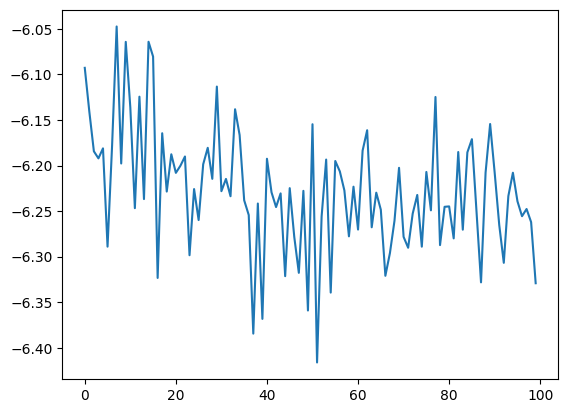

In [42]:
import matplotlib.pyplot as plt

plt.plot(energy_history)

### 4b. Use NetKet's optimisation driver

As writing the whole optimisation loop by yourself every time is.. boring, we can make use of a coupled of NetKet's built-in utilities.

In [43]:
# First we reset the parameters to run the optimisation again
vstate.init_parameters()

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

mf_energy = vstate.expect(H)
error = abs((mf_energy.mean - eig_vals[0]) / eig_vals[0])
print("Optimized energy and relative error: ", mf_energy, error)

100%|██████████| 300/300 [00:02<00:00, 106.03it/s, Energy=-6.282 ± 0.053 [σ²=3.6e-01, R̂=1.080]]


Optimized energy and relative error:  -6.177 ± 0.042 [σ²=2.2e-01, R̂=1.063] 0.045623501945124045


In [44]:
# we can also inspect the parameter:
print("Final optimized parameter: ", vstate.parameters["log_phi_local"])

Final optimized parameter:  [-2.67514282]


In [45]:
eig_vals[0]

np.float64(-6.472135954999582)

## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 2% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz.

We will now take a short-range Jastrow ansatz, entangling nearest and next-to nearest neighbors, of the form

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_i J_1 \sigma^{z}_i\sigma^{z}_{i+1} + J_2 \sigma^{z}_i\sigma^{z}_{i+2} \right),$$

where the parameters $J_1$ and $J_2$ are to be learned.

Again we can write the model using flax.

In [46]:
class JasShort(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):

        # Define two parameters j1, and j2.
        # Initialise them with a random normal distribution of standard deviation
        # 0.01
        # We must get a different key for each parameter, otherwise they will be
        # initialised with the same value.
        self.j1 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)
        self.j2 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)

    def __call__(self, x: jax.Array):

        # compute the nearest-neighbor correlations
        corr1 = x * jnp.roll(x, -1, axis=-1)
        corr2 = x * jnp.roll(x, -2, axis=-1)

        # sum the output
        return jnp.sum(self.j1 * corr1 + self.j2 * corr2, axis=-1)


# Initialise the model wtih seed 1
model = JasShort(rngs=nnx.Rngs(1))

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner. Also, we now log the intermediate results of the optimization, so that we can visualize them at a later stage.

Loggers that work together with optimisation drivers are defined in `nk.logging`. In this example we use `RuntimeLog`, which keeps the metrics in memory. You could also use `JsonLog`, which stores data to a json file which can be later read as a dict or `TensorBoardLog` which connects to [TensorBoard](https://www.tensorflow.org/tensorboard).

In [52]:
optimizer = nk.optimizer.Sgd(learning_rate=0.01)

gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

# construct the logger
log = nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

print(
    f"Final optimized parameters: j1={vstate.parameters['j1']}, j2={vstate.parameters['j2']}"
)

jas_energy = vstate.expect(H)
error = abs((jas_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error}")

100%|██████████| 300/300 [00:01<00:00, 295.57it/s, Energy=-6.4598 ± 0.0058 [σ²=3.4e-02, R̂=1.006]]


Final optimized parameters: j1=[0.2324392], j2=[0.08009992]
Optimized energy : -6.4755 ± 0.0057 [σ²=3.3e-02, R̂=1.008]
relative error   : 0.0005178882996293373


You can now see that this ansatz is almost one order of magnitude more accurate than the mean field!

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, here we have just used a simple one that stores the intermediate results as values in a dictionary.

In [53]:
data_jastrow = log.data
print(data_jastrow)

HistoryDict with 2 elements:
	'Energy' -> History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=300)
	'acceptance' -> History(keys=['value'], n_iters=300)


These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.

Text(0, 0.5, 'Energy')

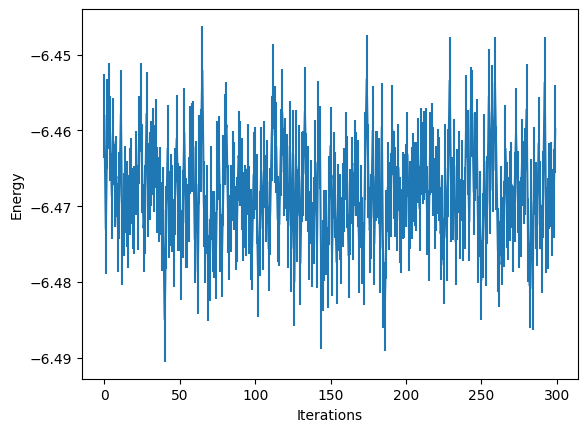

In [54]:
from matplotlib import pyplot as plt

plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
)
plt.xlabel("Iterations")
plt.ylabel("Energy")

## 6. Neural-Network Quantum State

We now want to use a more sophisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation.

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer.

In [55]:
class FFN(nnx.Module):

    def __init__(self, N: int, alpha: int = 1, *, rngs: nnx.Rngs):
        """
        Construct a Feed-Forward Neural Network with a single hidden layer.

        Args:
            N: The number of input nodes (number of spins in the chain).
            alpha: The density of the hidden layer. The hidden layer will have
                N*alpha nodes.
            rngs: The random number generator seed.
        """
        self.alpha = alpha

        # We define a linear (or dense) layer with `alpha` times the number of input nodes
        # as output nodes.
        # So we obtain a learnable matrix of shape (N, N*alpha)
        # We must pass forward the rngs object to the dense layer.
        self.linear = nnx.Linear(in_features=N, out_features=alpha * N, rngs=rngs)

    def __call__(self, x: jax.Array):

        # we apply the linear layer to the input
        y = self.linear(x)

        # the non-linearity is a simple ReLu
        y = nnx.relu(y)

        # sum the output
        return jnp.sum(y, axis=-1)


model = FFN(N=N, alpha=1, rngs=nnx.Rngs(2))

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

We then proceed to the optimization as before.

In [56]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0]) / eig_vals[0])
print("Optimized energy and relative error: ", ffn_energy, error)

100%|██████████| 300/300 [00:02<00:00, 137.18it/s, Energy=-6.4721367 ± 0.0000035 [σ²=1.3e-08, R̂=1.003]]


Optimized energy and relative error:  -6.4721354 ± 0.0000032 [σ²=1.0e-08, R̂=1.012] 7.850925711665835e-08


And we can compare the results between the two different Ansätze:

Text(0, 0.5, 'Energy')

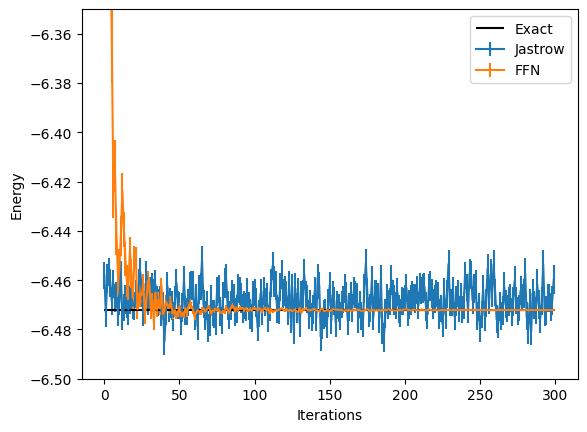

In [63]:
data_FFN = log.data

plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
    label="Jastrow",
)
plt.errorbar(
    data_FFN["Energy"].iters,
    data_FFN["Energy"].Mean,
    yerr=data_FFN["Energy"].Sigma,
    label="FFN",
)
plt.hlines([E_gs], xmin=0, xmax=300, color="black", label="Exact")
plt.legend()

plt.ylim(-6.5, -6.35)
plt.xlabel("Iterations")
plt.ylabel("Energy")

## 7. Translation Symmetry

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers.

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group.


In [71]:
graph = nk.graph.Chain(length=N, pbc=True)

print(graph.translation_group())

TranslationGroup(lattice:
Lattice(
    n_nodes=5,
    extent=[5],
    basis_vectors=
        [[1.]],
    site_offsets=
        [[0.]],
)

axes:(0,))


Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as

In [67]:
Gamma = -1
H = sum([Gamma * sigmax(hi, i) for i in range(N)])

V = -1
H += sum([V * sigmaz(hi, i) * sigmaz(hi, j) for (i, j) in graph.edges()])

We now write a model with an invariant transformation given by the translation group. Notice that we will now use NetKet's own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.

In [68]:
import flax.linen as nn
import netket.nn as nknn


class SymmModel(nnx.Module):

    def __init__(self, N: int, alpha: int = 1, *, rngs: nnx.Rngs):
        """
        Construct a Feed-Forward Neural Network with a single hidden layer.

        Args:
            N: The number of input nodes (number of spins in the chain).
            alpha: The density of the hidden layer. The hidden layer will have
                N*alpha nodes.
            rngs: The random number generator seed.
        """
        self.alpha = alpha

        # We want to use netket's DenseSymm layer, which requires a symmetry group.
        dense_symm_linen = nknn.DenseSymm(
            symmetries=graph.translation_group(),
            features=alpha,
            kernel_init=nn.initializers.normal(stddev=0.01),
        )
        # However, this layer is defined using ``flax.linen``, so to use it with NNX we
        # must resort to the conversion function ``nnx.bridge.ToNNX``.
        # The syntax is a bit weird, as we need to separately pass the random number generator
        # and then initialize the layer with a dummy input of shape (1, 1, Nsites).
        self.linear_symm = nnx.bridge.ToNNX(dense_symm_linen, rngs=rngs).lazy_init(
            jnp.ones((1, 1, N))
        )

    def __call__(self, x: jax.Array):
        # add an extra dimension with size 1, because DenseSymm requires rank-3 tensors as inputs.
        # the shape will now be (batches, 1, Nsites)
        x = x.reshape(-1, 1, x.shape[-1])

        x = self.linear_symm(x)
        x = nnx.relu(x)

        # sum the output
        return jnp.sum(x, axis=(-1, -2))


sampler = nk.sampler.MetropolisLocal(hi)

# Let us define a model with 4 features per symmetry
model = SymmModel(N=N, alpha=4, rngs=nnx.Rngs(2))

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

vstate.n_parameters

24

As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model, using a few more optimization steps than before.

In [72]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=600, out=log)

symm_energy = vstate.expect(H)
error = abs((symm_energy.mean - eig_vals[0]) / eig_vals[0])
print("Optimized energy and relative error: ", symm_energy, error)

100%|██████████| 600/600 [00:12<00:00, 48.32it/s, Energy=-6.4721359549995894 ± 0.0000000000000031 e+00 [σ²=9.5e-27, R̂=1.007]]  


Optimized energy and relative error:  -6.4721359549995867 ± 0.0000000000000063 e+00 [σ²=4.0e-26, R̂=1.005] 6.861555643110579e-16


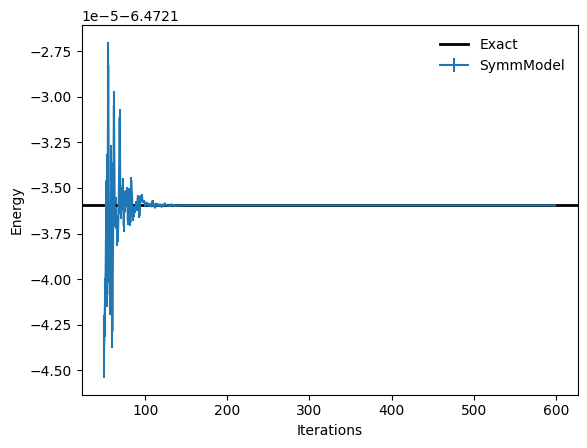

In [73]:
plt.errorbar(
    log.data["Energy"].iters[50:],
    log.data["Energy"].Mean[50:],
    yerr=log.data["Energy"].Sigma[50:],
    label="SymmModel",
)

plt.axhline(
    y=eig_vals[0],
    xmin=0,
    xmax=log.data["Energy"].iters[-1],
    linewidth=2,
    color="k",
    label="Exact",
)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.legend(frameon=False)

## 8. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $X-X$ correlator.
Notice that since correlators do not enjoy the zero-variance principle as the Hamiltonian instead does, it is important to use a larger number of samples to have a sufficiently low error bar on their measurement.


In [74]:
corr = sum([sigmax(hi, i) * sigmax(hi, j) for (i, j) in graph.edges()])

In [75]:
vstate.n_samples = 400000

In [76]:
vstate.expect(corr)

2.8832 ± 0.0064 [σ²=7.7e+00, R̂=1.000]

And we can further compare this to the exact ED result.

In [77]:
psi = eig_vecs[:, 0]
exact_corr = psi @ (corr @ psi)
print(exact_corr)

2.8944271909999157
